In [96]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [97]:
#Tried to use LaTeX, it didn't work
#Source: https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/tex_demo.html
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

In [98]:
csv_path_1 = os.path.join("data","clinicaltrial_data.csv")
csv_path_2 = os.path.join("data","mouse_drug_data.csv")

In [99]:
df_1 = pd.read_csv(csv_path_1)
df_2 = pd.read_csv(csv_path_2)
#df_2 has a Mouse ID g989 which has been listed as receiving two drugs, 
#which is outsidde the parameters of the study.  Therefore,
#we remove this mouse ID from the data

df_1 = df_1[df_1['Mouse ID']!='g989']
df_2 = df_2[df_2['Mouse ID']!='g989']
df_3 = pd.merge(df_1,df_2,on="Mouse ID",how="inner")
df_3 = df_3.rename(columns = {'Timepoint':'Time (Days)'})

In [100]:
# We only wish to study Capomulin, Infubinol, Ketapril, and Placebo
# We remove all other drugs from the data set
treatment_list = ['Capomulin','Infubinol','Ketapril','Placebo']
color_dict = {'Capomulin':'purple','Infubinol':'orange','Ketapril':'teal','Placebo':'pink'}
df_clean = df_3.loc[[(df_3['Drug'][i] in treatment_list) for i in range(len(df_3))]]


In [6]:
df_clean.iloc[[100,200,300,400,500],:]

,Mouse ID,Time (Days),Tumor Volume (mm3),Metastatic Sites,Drug
220,c139,25,61.461970,0,Infubinol
320,u327,35,58.089028,1,Ketapril
885,a203,0,45.000000,0,Infubinol
1177,v989,0,45.000000,0,Placebo
1410,a685,45,66.083066,3,Infubinol


In [7]:
drug_gb = df_clean.groupby("Drug")

In [101]:
def scat(drug,x_label,y_label,xlims,ylims):
    #Inputs are all strings
    plt.figure()
    my_data = drug_gb.get_group(drug)[[x_label,y_label]]
    x_axis = my_data[x_label]
    y_axis = my_data[y_label]
    color = color_dict[drug]
    plt.scatter(x_axis,y_axis,marker="o",c=color)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlims[0],xlims[1])
    plt.ylim(ylims[0],ylims[1])
    plt.title(f"{y_label} for treatment with {drug}")
    plt.savefig(f"{y_label}_{drug}.png")

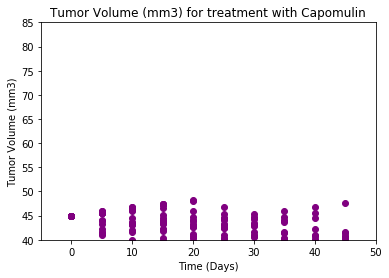

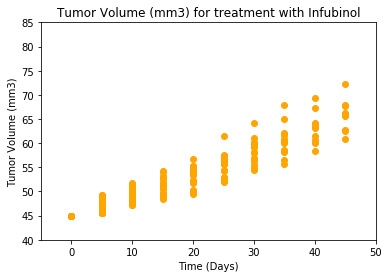

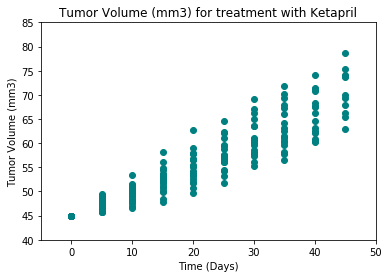

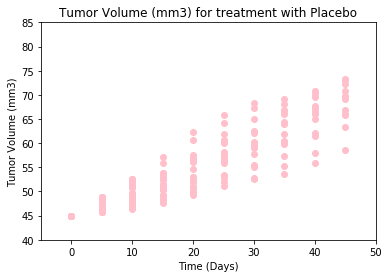

In [102]:
for i in treatment_list:
    scat(i,'Time (Days)','Tumor Volume (mm3)',[-5,50],[40,85])


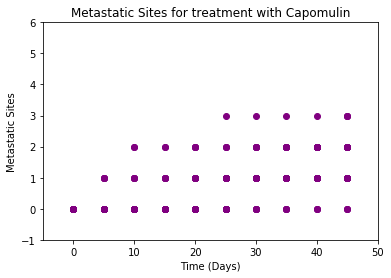

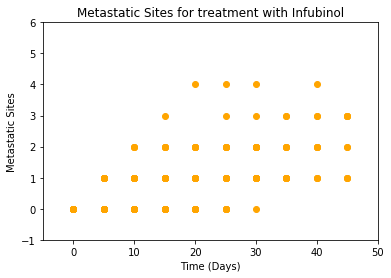

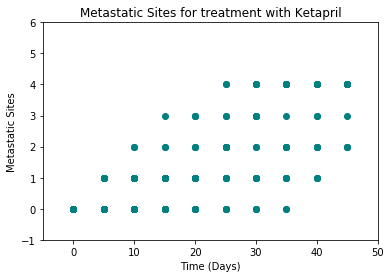

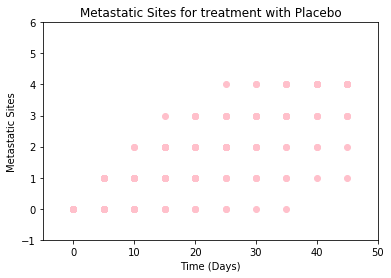

In [103]:
for i in treatment_list:
    scat(i,'Time (Days)','Metastatic Sites',[-5,50],[-1,6])

In [104]:
gb_dict = {}
for name,df in drug_gb:
    gb_dict[name]=df.groupby("Time (Days)")

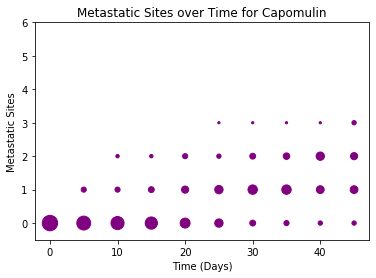

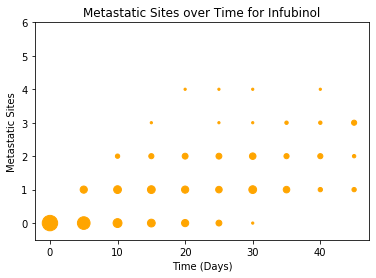

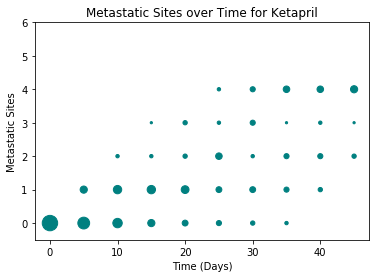

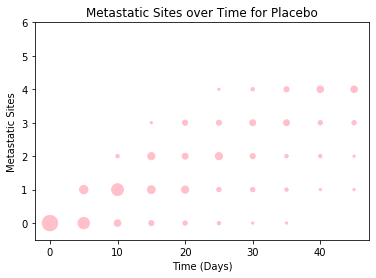

In [105]:
#Because the "scatter plots" above do not give a great visualization, I made another plot which illustrated the "overlapping"
#points using size

days = []
for name,frame in gb_dict['Placebo']:
    days.append(name)

for treatment in treatment_list:
    x_axis = []
    y_axis = []
    sizes = []
    color_list=[]
    for day in days:
        for i in range(7):
            data_present = True
            try:
                sz = gb_dict[treatment].get_group(day)['Metastatic Sites'].value_counts()[i]
                sizes.append(5*sz**1.2)
            except:
                 data_present = False               
            
            if data_present == True:
                x_axis.append(day)
                y_axis.append(i)
                color_list.append([sz/25,(1-sz)/25,0])
    plt.figure()
    plt.ylim(-0.5,6)    
    plt.scatter(x_axis,y_axis,s=sizes,c=color_dict[treatment])
    plt.title(f'Metastatic Sites over Time for {treatment}')
    plt.xlabel('Time (Days)')
    plt.ylabel('Metastatic Sites')
    plt.savefig(f"Metastatic_sites_variablesizes_{treatment}.png")

   

In [106]:
def ebar(drug,statistic,ylims):
    plt.figure()
    plt.errorbar(range(0,50,5),gb_dict[drug].mean()[statistic],gb_dict[drug].sem()[statistic],fmt="o",c=color_dict[drug])
    plt.xlabel("Time (Days)")
    plt.ylabel(f"Average {statistic} for {drug}")
    plt.ylim(ylims[0],ylims[1])
    plt.title(f"Mean of {statistic} for treatment with {drug}")
    plt.savefig(f"sems_for_{statistic}_{drug}.png")

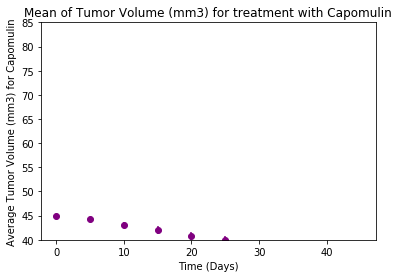

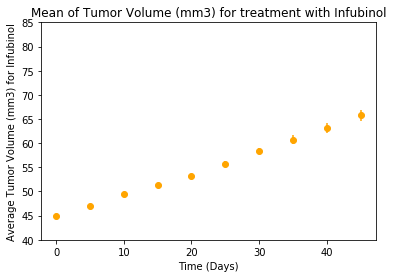

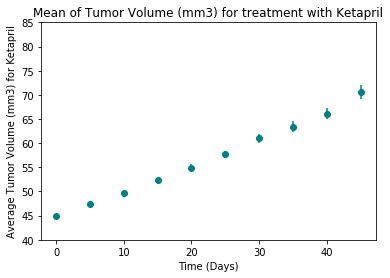

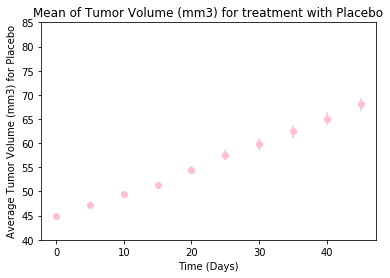

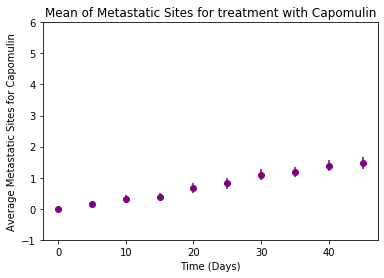

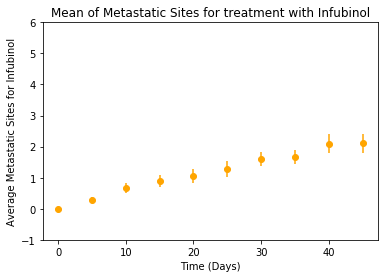

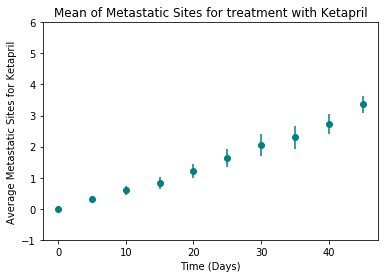

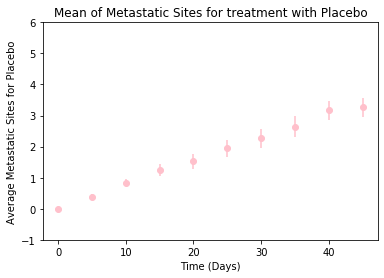

In [107]:
for stat in [["Tumor Volume (mm3)",[40,85]],["Metastatic Sites",[-1,6]]]:
    for treatment in treatment_list:
        ebar(treatment,stat[0],stat[1])

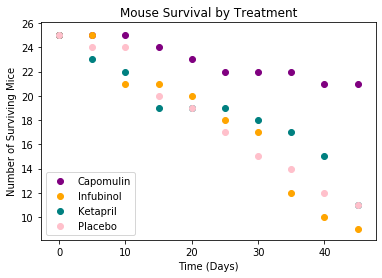

In [108]:
for treatment in treatment_list:
    plt.scatter(range(0,50,5),gb_dict[treatment].count()['Mouse ID'],marker="o",c=color_dict[treatment])

plt.xlabel("Time (Days)")
plt.ylabel("Number of Surviving Mice")
plt.title("Mouse Survival by Treatment")
plt.legend(treatment_list,loc=0)
plt.savefig(f"Mouse_survival_by_treatment.png")

In [109]:
#% change in average tumor volume is computed for each treatment
percent_change = []
for treatment in treatment_list:
    avg_vol_initial = gb_dict[treatment].mean()['Tumor Volume (mm3)'][0]
    avg_vol_final = gb_dict[treatment].mean()['Tumor Volume (mm3)'][45]
    percent_change.append((avg_vol_final-avg_vol_initial)/(avg_vol_initial))

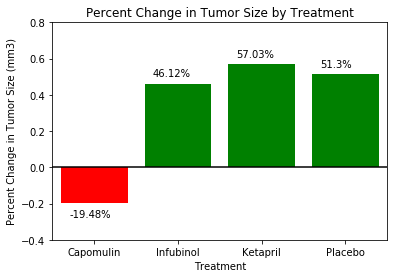

In [110]:
x_ticks = [i for i in range(len(treatment_list))]

#Used to position text on the bar graph
sign = []
for i in percent_change:
    if i>=0:
        sign.append(0.04)
    elif i<=0:
        sign.append(-0.08)
        
        
colors = []
for i in range(len(treatment_list)):
    if percent_change[i]>0:
        colors.append('g')
    else:
        colors.append('r')
#Colors Credit: https://python-graph-gallery.com/3-control-color-of-barplots/
#Bar Labeling Credit: 
plt.bar(treatment_list,percent_change,color=colors)
plt.hlines(0,-0.5,3.5)
plt.xlim(-0.5,3.5)
plt.ylim(-0.4,0.8)
plt.title("Percent Change in Tumor Size by Treatment")
plt.ylabel("Percent Change in Tumor Size (mm3)")
plt.xlabel("Treatment")
for i in range(len(treatment_list)):
    plt.annotate(f"{round(100*percent_change[i],2)}%",(x_ticks[i]-0.3,percent_change[i]+sign[i]))
plt.show()